## CNN

Implement image classification using CIFAR dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

## Hyperparameters

In [3]:
batch_size = 4
num_epochs = 4
learning_rate = 0.001

## Data set load and transform

transformation : dataset has PIL (python imaging library) images with values in range 
0 to 1, make it -1 to 1 using transformation

So two transformations composed using Compose  
1) Convert to tensor
2) Normalize

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
## transforms Normalize takes two arguments - mean across each channel (0.5, 0.5, 0.5) as 3 channels
## standard deviation across each channel (0.5, 0.5, 0.5)

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./data/', 
                                           train=True, transform=transforms.ToTensor(),download=True)

Files already downloaded and verified


In [6]:
test_dataset = torchvision.datasets.CIFAR10(root='./data/', 
                                           train=False, transform=transforms.ToTensor(),download=True)

Files already downloaded and verified


In [7]:
len(train_dataset)

50000

In [8]:
len(test_dataset)

10000

In [9]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
## 3 channels, 32*32 per channel

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [11]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [12]:
classes = ('plane', 'car', 'bird',
          'cat', 'deer', 'dog',
          'frog', 'horse', 'ship', 'truck')

## Implement Convnet

Architecture below

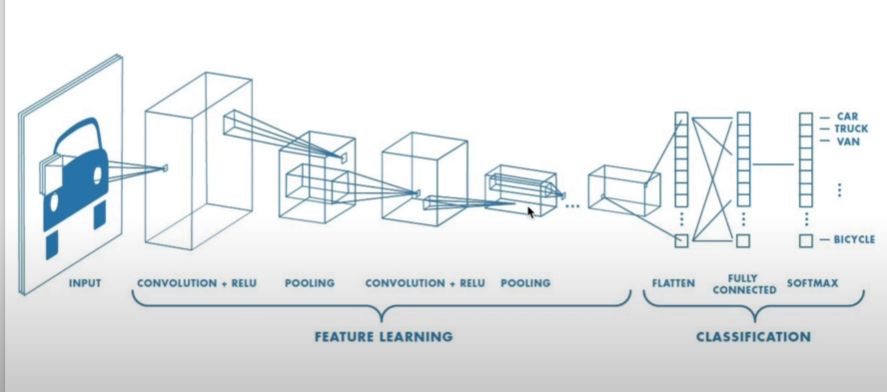

Convlution width output formula

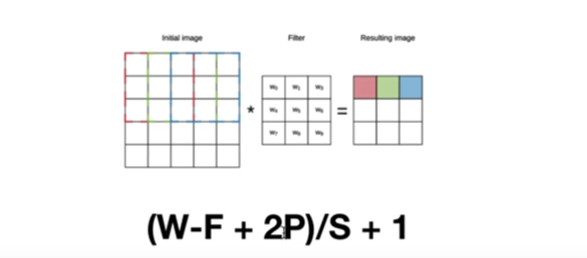

Given input width, output width can be computed this way

In [13]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5) ## input 3 channels, output 6 channels, kernel size 5*5
        self.pool = nn.MaxPool2d(2, 2) ## kernel_size 2*2, stride size 2
        self.conv2 = nn.Conv2d(6, 16, 5) ## input 6 channels (output of conv1), output 16 channels, kernel size 5*5
        
        ## fully connected layers
        self.fc1 = nn.Linear(16*5*5, 120) ## why 16*5*5 ? The convolution math works out , we will come to it in forward pass code below
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) ## final layer on which softmax is applied
        
    def forward(self, x):
        ## input dimension : batch_size * no of input channels * height*width which is 4*3*32*32 here
        ## First convolution and pooling layer
        x = self.conv1(x) ## output dimension : 4*6*28*28 -> no of samples remain same, 16 channels as self.conv1 has 16 as no of output channels,
                          ## using formula above, input width is 32, kernel size 5, no padding, stride 1, therefore, output width is ((32-5+2*0)/1) + 1 = 28
        
        x = F.relu(x)  ## dimensions remain same, relu does not affect
        x = self.pool(x) ## pooling with width 2 and stride 2, so output dimension is 
                        ## 4*6*14*14
        
        ## Second convolution and pooling layer
        x = self.conv2(x) ## using formula, output dimension is 4*16*10*10
        x = F.relu(x) ## dimensions remain same, relu does not affect
        x = self.pool(x) ## pooling with width 2 and stride 2, so output dimension is 
                        ## 4*16*5*5
            
        ## flatten ( to convert from 4*16*5*5 to 4* 400)
        x = x.view(-1, 16*5*5)  ## the -1 is to infer sample size of 4
            
        ## 3 linear layers
        x = self.fc1(x) ## input 4*400, output is 4*120
        x = F.relu(x)
        
        x = self.fc2(x) ## input 4*120, output is 4*84
        x = F.relu(x)
        
        x = self.fc3(x) ## input 4*84, output is 4*10
        
        return x ## no need to separately apply softmax as nn.CrossEntropyLoss takes softmax internally
        
        
        

In [14]:
model = ConvNet()
model = model.to(device)

## Define loss and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Actual training loop

In [16]:
n_total_steps = len(train_loader)

In [ ]:
n_total_steps

In [17]:
for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
        
        ## original shape : 4,3,32,32 -  batch_size 4, 3 channels, each image 32*32
        
        images = images.to(device)
        labels = labels.to(device)
        
        ## forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        ## backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        ## print
        if (i+1)%2000 == 0:
            print(f'epoch : [{epoch+1}/{num_epochs}], step in current epoch : [{i+1}/{n_total_steps}, loss : {loss.item():.4f}]')
        
        
    

epoch : [1/4], step in current epoch : [2000/12500, loss : 2.3115]
epoch : [1/4], step in current epoch : [4000/12500, loss : 2.3194]
epoch : [1/4], step in current epoch : [6000/12500, loss : 2.2956]
epoch : [1/4], step in current epoch : [8000/12500, loss : 2.3242]
epoch : [1/4], step in current epoch : [10000/12500, loss : 2.2669]
epoch : [1/4], step in current epoch : [12000/12500, loss : 2.3040]
epoch : [2/4], step in current epoch : [2000/12500, loss : 2.0833]
epoch : [2/4], step in current epoch : [4000/12500, loss : 1.7588]
epoch : [2/4], step in current epoch : [6000/12500, loss : 2.0040]
epoch : [2/4], step in current epoch : [8000/12500, loss : 1.5024]
epoch : [2/4], step in current epoch : [10000/12500, loss : 1.7136]
epoch : [2/4], step in current epoch : [12000/12500, loss : 1.8954]
epoch : [3/4], step in current epoch : [2000/12500, loss : 2.2930]
epoch : [3/4], step in current epoch : [4000/12500, loss : 1.6096]
epoch : [3/4], step in current epoch : [6000/12500, loss :

## Testing

In [19]:
with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = [0 for i in range(len(classes))]
    
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        
        _, predicted = torch.max(output, 1) ## argmax of class
        
        n_samples = n_samples + labels.shape[0]
        n_correct = n_correct + (predicted==labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            n_class_samples[label] = n_class_samples[label] + 1
            if pred==label:
                n_class_correct[label] = n_class_correct[label] + 1
    acc = 100.0 * n_correct/n_samples

    print(f'Overall accuracy is {acc} percent')

    for i in range(len(classes)):
        acc = 100.0 * n_class_correct[i]/n_class_samples[i]
        print(f'Accuracy of class {classes[i]} is {acc} percent')
            
        
        
        
    

Overall accuracy is 42.71 percent
Accuracy of class plane is 49.6 percent
Accuracy of class car is 58.6 percent
Accuracy of class bird is 15.2 percent
Accuracy of class cat is 25.8 percent
Accuracy of class deer is 36.0 percent
Accuracy of class dog is 41.8 percent
Accuracy of class frog is 50.1 percent
Accuracy of class horse is 52.1 percent
Accuracy of class ship is 49.0 percent
Accuracy of class truck is 48.9 percent


In [20]:
model.fc1.in_features

400